# X-ray challenge

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ./drive/MyDrive/raw_data


/content/drive/MyDrive/raw_data


In [ ]:
%ls


bacterial_pneumonia/  covid-19/  normal/  viral_pneumonia/


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib.pyplot import imread
import pathlib

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
dataset_path = "/content/drive/MyDrive/trainset"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256), 
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 4253 files for training.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 1063 files for validation.


In [ ]:
val_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
class_names = train_ds.class_names
print(class_names)

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
#from tensorflow.keras.applications.vgg16 import preprocess_input

#prepos_train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
#image_batch, labels_batch = next(iter(prepos_train_ds))
#first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image)) 


-123.68 150.54538


In [ ]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


5.1700372e-05 1.0


In [ ]:
normalized_train_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_val_ds))
first_image_val = image_batch_val[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_val), np.max(first_image_val)) 

0.0032571233 1.0


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers 


def initialize_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))
    
    return model

In [ ]:
model = initialize_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56448)            

In [ ]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy','precision','F1'])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
model = compile_model(model)

In [ ]:
history = model.fit(normalized_train_ds,
          batch_size=32,
          epochs=100, validation_data=normalized_val_ds, callbacks=[es])

Epoch 1/100
133/133 [==============================] - 1295s 10s/step - loss: 1.1017 - accuracy: 0.5238 - val_loss: 0.5388 - val_accuracy: 0.7808
Epoch 2/100
133/133 [==============================] - 59s 429ms/step - loss: 0.5674 - accuracy: 0.7571 - val_loss: 0.5854 - val_accuracy: 0.7752
Epoch 3/100
133/133 [==============================] - 59s 425ms/step - loss: 0.5113 - accuracy: 0.7847 - val_loss: 0.5626 - val_accuracy: 0.7686
Epoch 4/100
133/133 [==============================] - 58s 423ms/step - loss: 0.4770 - accuracy: 0.7998 - val_loss: 0.5125 - val_accuracy: 0.8053
Epoch 5/100
133/133 [==============================] - 59s 426ms/step - loss: 0.4206 - accuracy: 0.8127 - val_loss: 0.5715 - val_accuracy: 0.7808
Epoch 6/100
133/133 [==============================] - 59s 425ms/step - loss: 0.3956 - accuracy: 0.8399 - val_loss: 0.5442 - val_accuracy: 0.7968
Epoch 7/100
133/133 [==============================] - 59s 429ms/step - loss: 0.3563 - accuracy: 0.8417 - val_loss: 0.5859 -

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
import matplotlib.pyplot as plt

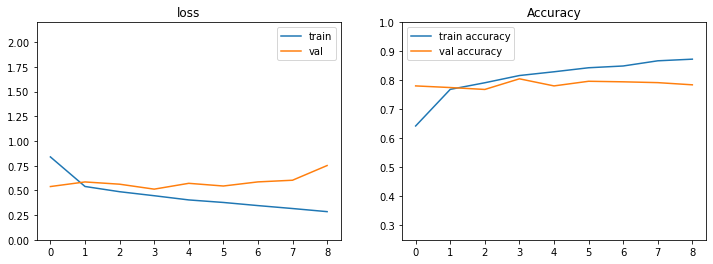

In [ ]:
plot_history(history)
plt.show()

In [ ]:
from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, '/content/drive/MyDrive/models/my_model')

NameError: ignored

In [ ]:
from tensorflow.keras import models
loaded_model = models.load_model('/content/drive/MyDrive/models/my_model')

In [ ]:
loaded_model

In [ ]:
dataset_path_test ="/content/drive/MyDrive/testset"

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path_test,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256), 
  batch_size=32)

Found 1346 files belonging to 4 classes.
Using 1077 files for training.


In [ ]:
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_test, labels_batch_test = next(iter(normalized_test_ds))
first_image_test = image_batch_test[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_test), np.max(first_image_test)) 

0.0 1.0


In [ ]:
loaded_model.evaluate(normalized_test_ds, verbose=1)



34/34 [==============================] - 11s 206ms/step - loss: 0.7251 - accuracy: 0.7122


[0.7251237630844116, 0.7121633887290955]

In [ ]:
labels = []
images = []
for image, label in normalized_test_ds:
  labels += list(np.array(label))
  images += list(np.array(image))

In [ ]:
np.array(labels).shape

(1077,)

In [102]:
y_true = np.array(labels)

In [ ]:
predictions = loaded_model.predict_generator(normalized_test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [100]:
y_pred = np.array([np.argmax(x) for x in predictions])

In [101]:
y_pred

array([2, 0, 0, ..., 3, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix

In [103]:
cm = confusion_matrix(y_true,y_pred)

In [104]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

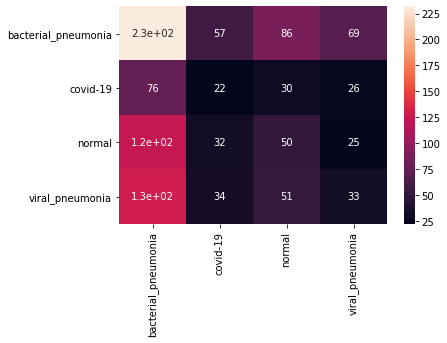

In [105]:
sns.heatmap(df_cm, annot=True)